# Ödev 3
Zaman Serisi Tahmini (Forecast)

1985 Ocak - 2015 Aralık arası aylık bazda ABD elektrik üretim verisini kullanarak (veri linki: "https://raw.githubusercontent.com/yasarkucukefe/YBS_405/main/data/Electric_Production.csv"), 2016 ve 2017 yılları için aylık elektrik üretimini ARIMA ve MLP (Multi Layer Perceptron) modelleri oluşturarak tahmin ediniz (forecast) ve gerçekleşen üretim ile modellerin tahmin değerlerini karşılaştırarak her iki modelin başarısını değerlendiriniz.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from matplotlib.dates import DateFormatter

plt.rcParams["figure.figsize"] = (15,3)

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/yasarkucukefe/YBS_405/main/data/Electric_Production.csv', parse_dates=["DATE"], index_col=['DATE'])

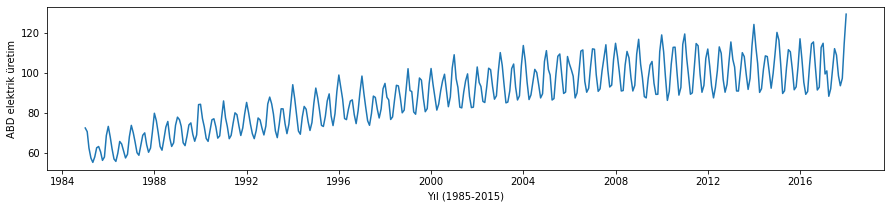

In [40]:
# Plot data
fig, ax = plt.subplots()
plt.plot(df)
plt.xlabel('Yıl (1985-2015)')
plt.ylabel('ABD elektrik üretim')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

In [43]:
trn = df.loc[df.index < '2016-01-01']
tst = df.loc[(df.index >= '2016-01-01') & (df.index <= '2017-12-01')]

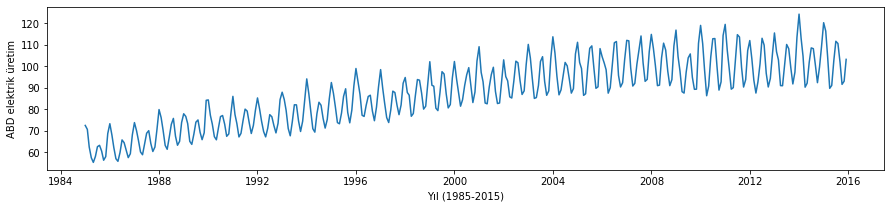

In [44]:
# eğitim veri seti
fig, ax = plt.subplots()
plt.plot(trn)
plt.xlabel('Yıl (1985-2015)')
plt.ylabel('ABD elektrik üretim')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

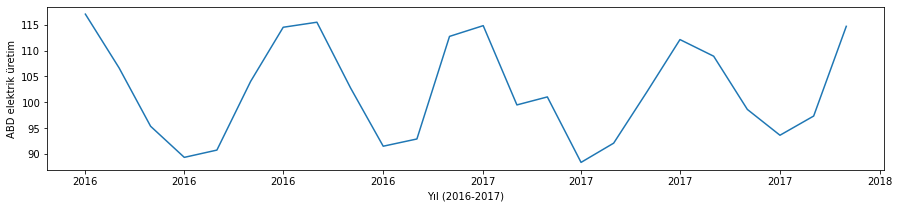

In [45]:
# test veri seti
fig, ax = plt.subplots()
plt.plot(tst)
plt.xlabel('Yıl (2016-2017)')
plt.ylabel('ABD elektrik üretim')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# ARIMA

In [54]:
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from pmdarima.arima import auto_arima

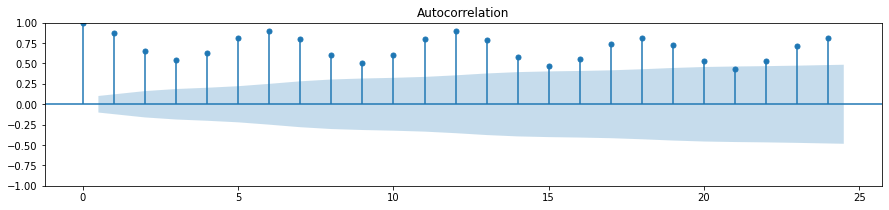

In [47]:
trn_acf = plot_acf(trn, lags=24)

In [50]:
# Doğrusal Regresyon (Linear Regression)
lr = sm.OLS(endog=trn['IPG2211A2N'],exog=sm.add_constant(np.arange(1,1+trn.shape[0]))).fit()
lr.summary

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x000001FA951AFB20>>

In [51]:
y_hat = lr.fittedvalues
y_ci = lr.get_prediction().conf_int(alpha=0.05)

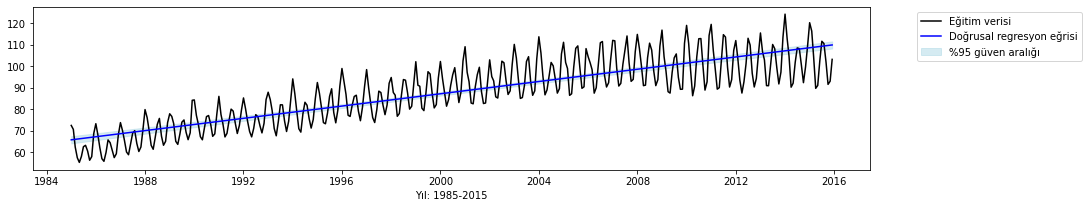

In [52]:
fig, ax = plt.subplots()
plt.xlabel('Yıl: 1985-2015')
plt.plot(trn, color='black', label='Eğitim verisi')
plt.plot(y_hat, color='blue', label='Doğrusal regresyon eğrisi')
plt.fill_between(y_hat.index, y_ci[:,0],y_ci[:,1], color='lightblue', alpha=0.5, label='%95 güven aralığı')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

In [55]:
auto_arima_model = auto_arima(trn, m=12, with_intercept=False, suppress_warnings=True)
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  372
Model:             SARIMAX(1, 1, 2)x(1, 0, 2, 12)   Log Likelihood                -843.684
Date:                            Mon, 20 Dec 2021   AIC                           1701.369
Time:                                    15:16:31   BIC                           1728.782
Sample:                                         0   HQIC                          1712.257
                                            - 372                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3475      0.096      3.637      0.000       0.160       0.535
ma.L1         -0.6988      0.096     -7.307      0.000      -0.886      -0.511
ma.L2         -0.2381      0.085     -2.791      0.005      -0.405      -0.071
ar.S.L12       0.9950      0.004    244.520      0.000       0.987       1.003
ma.S.L12      -0.6303      0.047    -13.272      0.000      -0.723      -0.537
ma.S.L24      -0.1110      0.053     -2.091      0.036      -0.215      -0.007
sigma2         5.0616      0.336     15.060      0.000       4.403       5.720
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                14.44
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.84   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
auto_arima_model.order

(1, 1, 2)

In [57]:
auto_arima_model.seasonal_order

(1, 0, 2, 12)

In [58]:
auto_arima_model.fit(trn)

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(1, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [68]:
arima_tahmin = auto_arima_model.predict(n_periods=24, alpha=0.05, return_conf_int=True)

In [69]:
y_tahmin = pd.Series(arima_tahmin[0], index=tst.index)
y_tahmin_lb, y_tahmin_up = arima_tahmin[1][:,0], arima_tahmin[1][:,1]

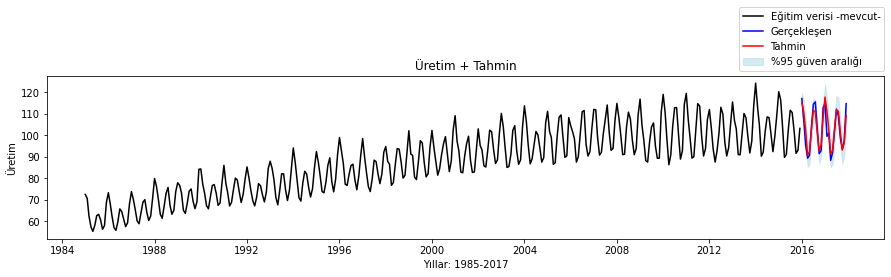

In [87]:
# Grafik
fig, ax = plt.subplots()
plt.xlabel("Yıllar: 1985-2017")
plt.ylabel('Üretim')
plt.title('Üretim + Tahmin')
plt.fill_between(tst.index, y_tahmin_lb, y_tahmin_up, color='lightblue', alpha=0.5, label='%95 güven aralığı')
plt.plot(trn, color='black', label='Eğitim verisi -mevcut-')
plt.plot(tst, color='blue', label='Gerçekleşen')
plt.plot(y_tahmin, color='red', label='Tahmin')
plt.legend(bbox_to_anchor=(0.82, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# MLP

In [113]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [88]:
k = 12
Z = []
for i in range(k+1, df.shape[0]+1):
    Z.append(df.iloc[(i-k-1):i, 0])
Z = np.array(Z)

In [89]:
Z.shape

(385, 13)

In [100]:
split = np.int32(0.8 * Z.shape[0])

Z_train, Z_test = Z[:split, :], Z[split:, :]

In [101]:
Z_test.shape

(77, 13)

In [104]:
scaler = StandardScaler().fit(Z_train)

Z_train = scaler.transform(Z_train)
Z_test = scaler.transform(Z_test)

In [105]:
X_train, y_train = Z_train[:, :-1], Z_train[:, -1]
X_test, y_test = Z_test[:, :-1], Z_test[:, -1]

In [107]:
split_ = np.int32(0.8 * X_train.shape[0])
X_train_, y_train_ = X_train[:split_,:], y_train[:split_]
X_valid_, y_valid_ = X_train[split_:,:], y_train[split_:]

In [108]:
print(X_train_.shape, y_train_.shape)
print(X_valid_.shape, y_valid_.shape)

(246, 12) (246,)
(62, 12) (62,)


In [109]:
def validation_loss(hidden_neurons):
    mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,), max_iter=500, random_state=1, shuffle=False)
    mlp.fit(X_train_, y_train_)
    return mean_squared_error(y_valid_, mlp.predict(X_valid_))

In [132]:
params = range(1, 50, 2)
mse = [validation_loss(p) for p in params]

C:\Users\Bilal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Bilal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


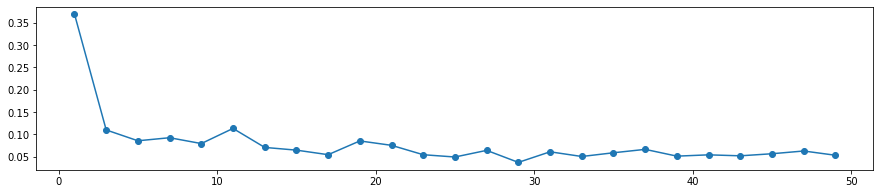

In [133]:
fig, ax = plt.subplots()
plt.plot(params, mse, '-o')

In [146]:
mlp = MLPRegressor(hidden_layer_sizes=(29,), max_iter=500, random_state=1, shuffle=False)

In [147]:
mlp.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(29,), max_iter=500, random_state=1,
             shuffle=False)

In [148]:
y_pred = mlp.predict(X_test)
y_pred

array([0.93621271, 0.38056161, 0.59890258, 1.79125475, 2.02329003,
       1.59453462, 0.73659628, 0.03908658, 0.31692054, 1.45570972,
       1.50503592, 1.5744276 , 0.69665705, 0.27615085, 0.60373314,
       1.58745329, 1.65455857, 1.67149318, 0.77437263, 0.34340141,
       0.32071831, 1.29383256, 1.53825466, 1.62482623, 0.85967908,
       0.27216058, 0.39646015, 1.46261326, 2.10268684, 1.9409654 ,
       0.9569499 , 0.39445932, 0.17765433, 1.35367264, 1.7519033 ,
       1.70469097, 0.91169784, 0.36391778, 0.57694628, 1.83813335,
       1.92950536, 1.8259031 , 1.04732558, 0.47961142, 0.12844474,
       1.25602643, 1.77854424, 1.73374152, 1.11601036, 0.42210453,
       0.45650792, 1.54374345, 1.95271643, 1.92076621, 0.78845002,
       0.23177722, 0.23867855, 1.26336636, 1.73092781, 1.67471674,
       1.03851019, 0.27050406, 0.50868293, 1.47095242, 2.39830945,
       1.72817607, 0.67955656, 0.27005275, 0.09199157, 1.35803746,
       1.73615173, 1.77371761, 0.60538736, 0.4337914 , 0.57607

In [149]:
y_test_ = scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1,1)]))[:, -1]
y_pred_ = scaler.inverse_transform(np.hstack([X_test, y_pred.reshape(-1,1)]))[:, -1]

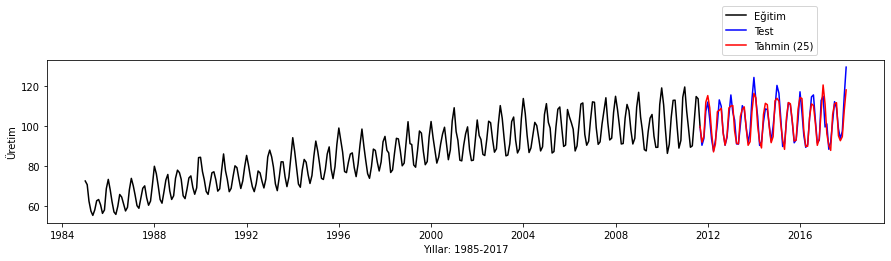

In [150]:
fig, ax = plt.subplots()
plt.xlabel("Yıllar: 1985-2017")
plt.ylabel('Üretim')
plt.plot(df.iloc[:(k + len(y_train) + 1), :], color='black', label='Eğitim')
plt.plot(pd.Series(y_test_, index=df.index[-len(y_test):]), color='blue', label='Test')
plt.plot(pd.Series(y_pred_, index=df.index[-len(y_test):]), color='red', label='Tahmin (25)')
plt.legend(bbox_to_anchor=(0.8, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))